In [118]:
import ccxt.pro as ccxtpro
import pandas as pd
import warnings
import time
import asyncio
import redis

warnings.filterwarnings("ignore")

exchange = ccxtpro.binance({
    'apiKey': '',
    'secret': '',
})
exchange.httpProxy = "http://127.0.0.1:7890"
exchange.wsProxy = 'http://127.0.0.1:7890'


async def monitor():
    r = redis.Redis(host='localhost', port=6379, db=0)
    r.delete('BTC/USDT_aggtrades')
    r.delete('ETH/USDT_aggtrades')
    while True:
        try:
            start_time = time.time()
            t = exchange.milliseconds()
            print(f'{'*' * 40}{exchange.iso8601(t)}{'*' * 40}')
            res = await exchange.watch_trades_for_symbols(["BTC/USDT", "ETH/USDT"])
            for row in res:
                s = f"{row['id']},{row['timestamp']},{0 if row['side'] == 'buy' else 1},{row['price']},{row['amount']},{row['cost']}"
                r.lpush(f'{row['symbol']}_aggtrades', s)
            print(f"run time {time.time() - start_time}s")
        except Exception as e:
            print(e)
def get_df(symbol='BTC/USDT'):
    r = redis.Redis(host='localhost', port=6379, db=0)
    n = r.llen(f'{symbol}_aggtrades')
    # print(n,type(n))
    df = pd.DataFrame(r.lrange(f'{symbol}_aggtrades', 0, n),dtype=str)
    df['id'] = df[0].apply(lambda x: x.split(',')[0]).astype(int)
    df['t'] = df[0].apply(lambda x: x.split(',')[1]).astype(int)
    df['dt'] = pd.to_datetime(df['t'], unit='ms',utc=True)
    df['side'] = df[0].apply(lambda x: x.split(',')[2]).astype(int)
    df['price'] = df[0].apply(lambda x: x.split(',')[3]).astype(float)
    df['amount'] = df[0].apply(lambda x: x.split(',')[4]).astype(float)
    df['cost'] = df[0].apply(lambda x: x.split(',')[5]).astype(float)
    df = df[['id','dt','t', 'side', 'price', 'amount', 'cost']]
    df.sort_values(by=['id'], ascending=True, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df
def calc_money_type(res_df: pd.DataFrame,type_arr=[1,0.5,0.1,0.01]):
    df = res_df.copy()
    df['money_type'] = df['amount'].apply(lambda x:5 if x>=type_arr[0] else (4 if x>=type_arr[1] else ( 3 if x>=type_arr[2] else (2 if x>=type_arr[3] else 1 )) ))
    df['money_type'] = df['money_type'] * (df['side'].apply(lambda x:-1 if x>0 else 1))
    return df

In [106]:
# await monitor()

In [107]:
btc_df = get_df('BTC/USDT')
btc_df

,id,dt,t,side,price,amount,cost
0,4315142356,2024-12-21 01:19:24.899000+00:00,1734743964899,0,97445.12,0.00102,99.394022
1,4315142357,2024-12-21 01:19:25.760000+00:00,1734743965760,1,97445.11,0.01004,978.348904
2,4315142358,2024-12-21 01:19:25.975000+00:00,1734743965975,0,97445.12,0.00840,818.539008
3,4315142359,2024-12-21 01:19:26.428000+00:00,1734743966428,0,97445.12,0.00013,12.667866
4,4315142360,2024-12-21 01:19:26.497000+00:00,1734743966497,0,97445.12,0.00102,99.394022
...,...,...,...,...,...,...,...
11724,4315154080,2024-12-21 01:24:21.362000+00:00,1734744261362,1,97571.23,0.00010,9.757123
11725,4315154081,2024-12-21 01:24:21.362000+00:00,1734744261362,1,97571.23,0.20507,20008.932136
11726,4315154082,2024-12-21 01:24:21.362000+00:00,1734744261362,1,97571.23,0.04326,4220.931410
11727,4315154083,2024-12-21 01:24:21.362000+00:00,1734744261362,1,97571.23,0.00078,76.105559


In [108]:
# money type
# btc Super Large order, top 0.01%， amount>=1
super_large_df =  btc_df.sort_values(by=['amount'], ascending=True)[-btc_df.shape[0]//10000:]
# btc Large order, top 0.1%， amount 0.5~1
large_df = btc_df.sort_values(by=['amount'], ascending=True)[-btc_df.shape[0]//1000:-btc_df.shape[0]//10000]
# btc middle order, top 1%， amount 0.5~1
middle_df = btc_df.sort_values(by=['amount'], ascending=True)[-btc_df.shape[0]//100:-btc_df.shape[0]//1000]
# btc small order, top 10%， amount 0.1~0.5
small_df = btc_df.sort_values(by=['amount'], ascending=True)[-btc_df.shape[0]//10:-btc_df.shape[0]//100]
# btc mini order, top 100~10%， amount 0~0.01
mini_df = btc_df.sort_values(by=['amount'], ascending=True)[-btc_df.shape[0]:-btc_df.shape[0]//10]
super_large_df['amount'].values[0], large_df['amount'].values[0],middle_df['amount'].values[0],small_df['amount'].values[0],mini_df['amount'].values[0]

(1.0, 0.54, 0.17813, 0.0111, 1e-05)

In [111]:
res_df = calc_money_type(btc_df,[1,0.5,0.1,0.01])
res_df

,id,dt,t,side,price,amount,cost,money_type
0,4315142356,2024-12-21 01:19:24.899000+00:00,1734743964899,0,97445.12,0.00102,99.394022,1
1,4315142357,2024-12-21 01:19:25.760000+00:00,1734743965760,1,97445.11,0.01004,978.348904,-2
2,4315142358,2024-12-21 01:19:25.975000+00:00,1734743965975,0,97445.12,0.00840,818.539008,1
3,4315142359,2024-12-21 01:19:26.428000+00:00,1734743966428,0,97445.12,0.00013,12.667866,1
4,4315142360,2024-12-21 01:19:26.497000+00:00,1734743966497,0,97445.12,0.00102,99.394022,1
...,...,...,...,...,...,...,...,...
11724,4315154080,2024-12-21 01:24:21.362000+00:00,1734744261362,1,97571.23,0.00010,9.757123,-1
11725,4315154081,2024-12-21 01:24:21.362000+00:00,1734744261362,1,97571.23,0.20507,20008.932136,-3
11726,4315154082,2024-12-21 01:24:21.362000+00:00,1734744261362,1,97571.23,0.04326,4220.931410,-2
11727,4315154083,2024-12-21 01:24:21.362000+00:00,1734744261362,1,97571.23,0.00078,76.105559,-1


In [112]:
# abs(money type) == 4
res_df[res_df['money_type'].abs()>=4]

,id,dt,t,side,price,amount,cost,money_type
1201,4315143557,2024-12-21 01:20:02.677000+00:00,1734744002677,1,97431.73,1.00000,97431.730000,-5
2643,4315144999,2024-12-21 01:20:23.361000+00:00,1734744023361,0,97344.02,0.57183,55664.230957,4
3811,4315146167,2024-12-21 01:20:35.439000+00:00,1734744035439,0,97361.05,0.54000,52574.967000,4
4484,4315146840,2024-12-21 01:20:50.937000+00:00,1734744050937,1,97348.00,0.60210,58613.230800,-4
5842,4315148198,2024-12-21 01:21:32.672000+00:00,1734744092672,0,97308.01,0.86578,84247.328898,4
7364,4315149720,2024-12-21 01:22:29.122000+00:00,1734744149122,0,97342.00,0.62996,61321.566320,4
7566,4315149922,2024-12-21 01:22:40.740000+00:00,1734744160740,0,97354.37,0.76011,74000.030181,4
7568,4315149924,2024-12-21 01:22:40.757000+00:00,1734744160757,0,97354.37,0.64000,62306.796800,4
7955,4315150311,2024-12-21 01:22:53.376000+00:00,1734744173376,0,97369.08,0.64414,62719.319191,4
8443,4315150799,2024-12-21 01:23:25.599000+00:00,1734744205599,0,97385.33,0.95535,93037.075015,4


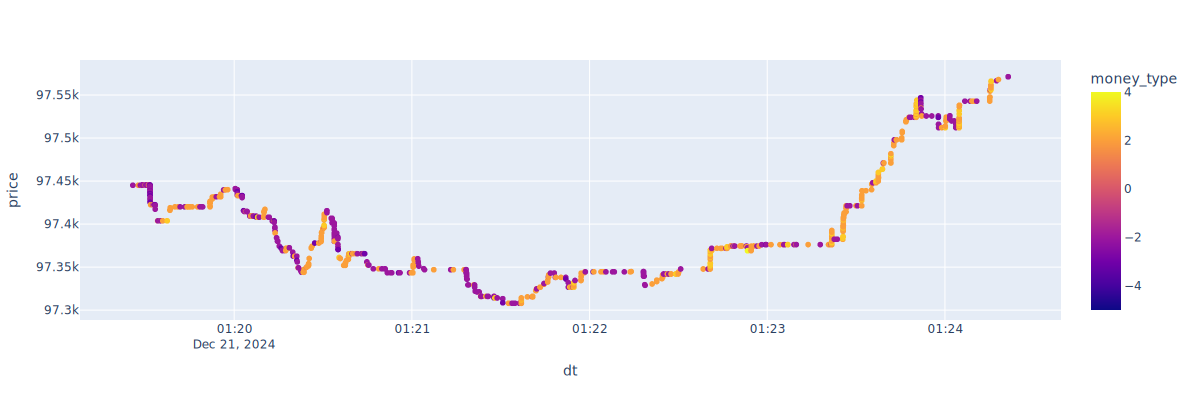

In [159]:
#
import plotly.express as px
fig = px.scatter(res_df[res_df['money_type'].abs()>=2], x='dt', y='price',color='money_type')
fig.show(width=1200,height=400,renderer='svg')
